In [4]:
import numpy as np 
import pandas as pd
import datetime
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import os
        
RANDOM_SEED = 42

In [5]:
train_df = pd.read_csv('/Users/noah/Documents/project/transportX/data/train.csv')
train_fastroute_df = pd.concat((pd.read_csv('/Users/noah/Documents/project/transportX/data/fastest_routes_train_part_1.csv'), pd.read_csv('/Users/noah/Documents/project/transportX/data/fastest_routes_train_part_2.csv')), axis = 0).reset_index(drop = True)

temperature_df = pd.read_csv('/Users/noah/Documents/project/transportX/data/temperature.csv')
humidity_df = pd.read_csv('/Users/noah/Documents/project/transportX/data/humidity.csv')
wind_speed_df = pd.read_csv('/Users/noah/Documents/project/transportX/data/wind_speed.csv')
wind_direction_df = pd.read_csv('/Users/noah/Documents/project/transportX/data/wind_direction.csv')

gc.collect()

0

In [6]:
def add_df_date_hour(df, string):
    """ 
    Utility function to add 'pickup_date' amd 'pickup_hour' for weather data.
    """
    date = pd.to_datetime(df['datetime'])
    df['pickup_date'] =  date.dt.date
    df['pickup_hour'] = date.dt.hour
    return df[['pickup_date', 'pickup_hour', 'New York']].rename(columns = {'New York' : string})

def merge_location_df(df, fastroute_df):
    """
    Utility function to merge fastroute df and city/county information from pickup and dropoff points.
    """
    
    df = df.merge(fastroute_df, on = 'id')    
    return df

def get_haversine_distance(lat_1, long_1, lat_2, long_2):
    """
    Calculate the distance of 2 points with consideration of the roundness of earth.
    """
    
    AVG_EARTH_RADIUS = 6371
    lat_1, long1, lat_2, long_2 = map(np.radians, (lat_1, long_1, lat_2, long_2))
    lat = lat_2 - lat_1 ; long = long_2 - long_1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(long * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_direction(lat_1, long_1, lat_2, long_2):
    """
    Calculates the angle or direction of 2 points with consideration of the roundness of earth.
    """
    
    AVG_EARTH_RADIUS = 6371  # in km
    long_delta_rad = np.radians(long_2 - long_1)
    lat_1, long_1, lat_2, long_2 = map(np.radians, (lat_1, long_1, lat_2, long_2))
    y = np.sin(long_delta_rad) * np.cos(lat_2)
    x = np.cos(lat_1) * np.sin(lat_2) - np.sin(lat_1) * np.cos(lat_2) * np.cos(long_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

def map_dic_to_dic(dic_1, dic_2):
    """
    Util function to map dictionary to dictionary
    """
    
    return {k : dic_2[v] for k, v in dic_1.items() if v in dic_2.keys()}

def merge_weather_df(df, temp_df, hum_df, ws_df, wd_df):
    """
    Utilty function to merge weather dataframes.
    """
    
    df = df.merge(temp_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    df = df.merge(hum_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    df = df.merge(ws_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    df = df.merge(wd_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    
    return df

def map_df_to_dic(df, dic, cols):
    """
    Utility function to map dataframe to dictionary.
    """
    
    for k, v in cols.items():
        df[k] = df[v].map(dic)
    return df

def data_preprocessing(df):
    """
    Data preprocessing for New York Taxi Trip Duration.
    """

    # Time Features
    df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['pickup_min'] = pd.to_datetime(df['pickup_datetime']).dt.minute
    df['pickup_day'] = pd.to_datetime(df['pickup_datetime']).dt.day
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime']).dt.date
    df['pickup_time'] = df['pickup_hour'] + (df['pickup_min'] / 60)
    df['pickup_dayofweek'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek
    df['pickup_weekday'] = 0
    df.loc[df['pickup_dayofweek'].isin([0, 1, 2, 3, 4]), 'pickup_weekday'] = 1
    
    df['displacement'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

    return df 

def agggregate_processing(train):
    """
    Data aggregation process on both train and test dataset for New York Taxi Trip Duration.
    """
    #Rotated features from PCA
    coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                        train[['dropoff_latitude', 'dropoff_longitude']].values))

    pca = PCA().fit(coords)
    train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
    train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
    train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    train = train[(train.trip_duration < 10000)]
    filename = 'pca_model.sav'
    pickle.dump(pca, open(filename, 'wb'))    
    return train

In [7]:
# Main processing

temperature_df = add_df_date_hour(temperature_df, 'temperature')
humidity_df = add_df_date_hour(humidity_df, 'humidity')
wind_speed_df = add_df_date_hour(wind_speed_df, 'wind_speed')
wind_direction_df = add_df_date_hour(wind_direction_df, 'wind_direction')

train_df = merge_location_df(train_df,train_fastroute_df)
train_df = data_preprocessing(train_df)
train_df = merge_weather_df(train_df, temperature_df, humidity_df, wind_speed_df, wind_direction_df)
train_df = agggregate_processing(train_df)

In [8]:
#Preparing parameter for Stratification of Target with quantiles
train_df['bin_target'] = 0
train_df.loc[(train_df['trip_duration'] >= 397.0) & (train_df['trip_duration'] < 662.0), 'bin_target'] = 1
train_df.loc[(train_df['trip_duration'] >= 662.0) & (train_df['trip_duration'] < 1075.0), 'bin_target'] = 2
train_df.loc[(train_df['trip_duration'] >= 1075.0), 'bin_target'] = 3

In [9]:
# Final Features to be pushed for modeling
features = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','pickup_day', 'pickup_time', 'pickup_dayofweek', 'pickup_weekday',
       'displacement', 'direction', 'temperature', 'humidity', 'wind_speed',
       'wind_direction', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1','total_distance']

In [10]:
print(len(features))

19


In [11]:
train, test = train_test_split(train_df, train_size = 0.8, test_size = 0.2)

In [12]:
params = {
    'objective': 'regression',
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 ,
    'num_threads' : -1}

target = np.log(train[['trip_duration']] + 1)

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED)
oof = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

for _fold, (train_index, eval_index) in enumerate(folds.split(train, train['bin_target'])):
    print(f"\nFold: {_fold} \n-------------------------")
    x_train = train.iloc[train_index][features].values ; y_train = target.iloc[train_index]
    x_eval = train.iloc[eval_index][features].values ; y_eval = target.iloc[eval_index]

    train_data = lgbm.Dataset(x_train, y_train)
    eval_data = lgbm.Dataset(x_eval, y_eval)

    model = lgbm.train(params, train_data, num_boost_round=1500, valid_sets= (train_data, eval_data),
                early_stopping_rounds=100, verbose_eval=100)

    eval_pred = model.predict(train.iloc[eval_index][features], num_iteration = model.best_iteration)

    oof[eval_index] = eval_pred

    test_pred += (np.exp(model.predict(test[features], num_iteration = model.best_iteration)) - 1) / folds.n_splits 

    fold_importance_df = pd.DataFrame()
    fold_importance_df['Features'] = features
    fold_importance_df['Importance'] = model.feature_importance()
    feature_importance_df = pd.concat((feature_importance_df, fold_importance_df), axis = 0)


Fold: 0 
-------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13398
[LightGBM] [Info] Number of data points in the train set: 932172, number of used features: 19
[LightGBM] [Info] Start training from score 6.459742
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.274173	valid_1's rmse: 0.336069
[200]	training's rmse: 0.247922	valid_1's rmse: 0.333521
[300]	training's rmse: 0.228286	valid_1's rmse: 0.332652
[400]	training's rmse: 0.212992	valid_1's rmse: 0.332307
[500]	training's rmse: 0.19964	valid_1's rmse: 0.331942
[600]	training's rmse: 0.187497	valid_1's rmse: 0.331774
[700]	training's rmse: 0.175763	valid_1's rmse: 0.331685
[800]	training's rmse: 0.165659	valid_1's rmse: 0.331741
Early stopping, best iteration is:
[


--------------------------------------
 LGBM results After Feature Engineering
--------------------------------------
Overall RMSE out-of-folds: 0.3313025251926923


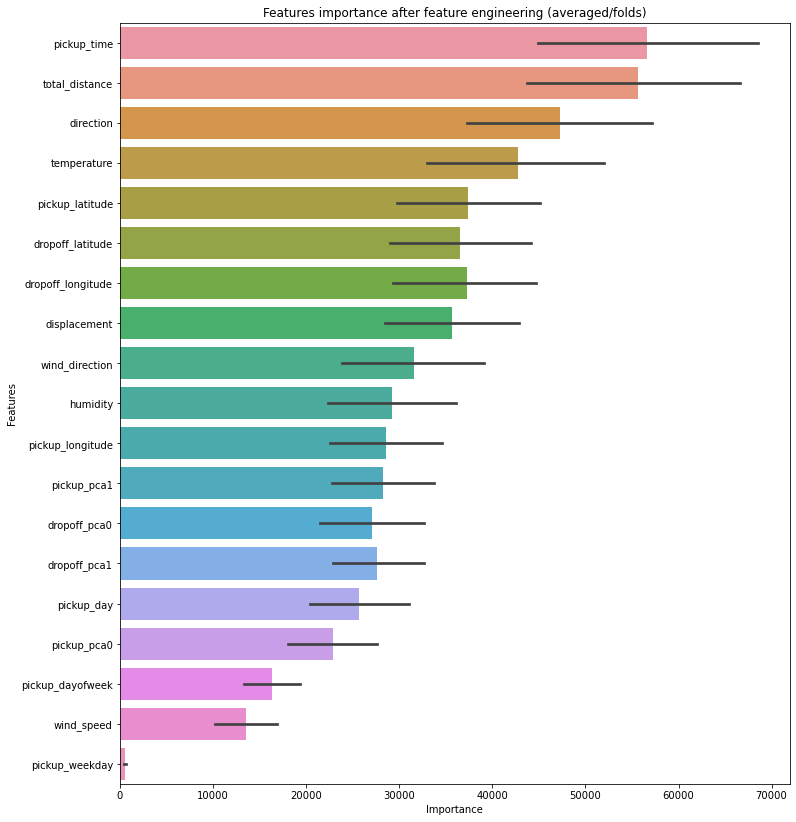

In [27]:
print("\n--------------------------------------\n LGBM results After Feature Engineering\n--------------------------------------")
print(f"Overall RMSE out-of-folds: {np.sqrt(mse(target, oof))}")

cols = (feature_importance_df[["Features", "Importance"]]
        .groupby("Features").mean().sort_values(by="Importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df['Features'].isin(cols)]

plt.figure(figsize=(12,14))
sns.barplot(x="Importance", y="Features", data=best_features.sort_values(by="Importance",ascending=False))
plt.title('Features importance after feature engineering (averaged/folds)')
plt.show()

In [38]:
test_pred = np.exp(model.predict(test[features]))-1

In [40]:
mean_absolute_error(test.trip_duration,test_pred)

155.00689844690726

In [14]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
# some time later...
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [8]:
train_df.to_csv('data.csv')